In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math

In [17]:
def get_stock(start, end, stock, restricted_days):
    '''
    Return the data as Numpy arrays and incrementing indexes for each value for the time series.

    Parameters:
    -- start: start date "Year-Month-Day"
    -- end: end date "Year-Month-Day"
    -- stock: The label of the stock to download from yahoo stocks
    -- restriced_days: int, the number of last days to be removed from the dataframe 

    Returns:
    -- df: 1d Numpy array containing all the closing prices from the start to end data except for the last 100 days
    -- restricted_df: Contains the last <restriced_days> days of the data
    -- index: incrementing indexes for the closing prices
    '''
    
    yfd = yf.download(stock, start=start, end=end)
    df = pd.DataFrame({'Close': yfd['Close']})
    df = df.dropna().reset_index(drop=True)

    restricted_df = np.array(df[len(df) - restricted_days:]) # last 100 days prices
    df = np.array(df[:len(df) - restricted_days]) # remove the restricted days from the main df
    index = np.linspace(1, df.shape[0], df.shape[0])

    return df, restricted_df, index 

def bin_data(df, bin_size):
    '''
    Returns the data split into bins of size <bin_size>. The bins are used to predict the day on index <bin_size> + 1.
    
    Parameters:
    -- df: dataset containing the closing prices for the stock
    -- bin_size: size of bins for the data

    Returns:
    -- bins: Numpy array size (len(df) - bin_size, bin_size), bins created based on a sliding window incrementing by 1
    '''
    
    bins = np.array([df[i:i + bin_size].T.reshape(-1) for i in range(0, len(df) - bin_size - 1, 1)])
    return bins 

def split_data(bins, df, index, bin_size):
    # Generally it is good practice to train data on 80 % of the data and test on 20%
    train_size = math.floor(len(bins)* 0.8) # 80% of the data
    test_size = len(bins) - train_size # 20% of the data
    assert train_size + test_size == len(bins)
    
    # split into X and y
    X_train = np.array(bins[:train_size])
    y_train = np.array(df[bin_size:bin_size + train_size]).T.reshape(-1)
    train_index = index[:train_size]
    
    X_test = np.array(bins[train_size:])
    y_test = np.array(df[bin_size + train_size: bin_size + train_size + test_size]).T.reshape(-1) # the value after the bin_size
    test_index = index[train_size + 1: train_size + 1 + test_size]

    return X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size

In [15]:
''' Define stocks '''
# [name, start-date, end-date]
stock = ['^GSPC', '1980-01-01', '2024-10-01']
restrict = 100 # Use the last 100 days for autoregressive testing
bin_size = 365 # We require the past year of data

df, restricted_df, index = get_stock(stock[1], stock[2], stock[0], restrict)

# TODO:
# 1.) print out the function output and see what the data looks like
# 2.) Look how the function obtained and edited the dataframe
# 3.) Change the date and compare this with the real stock data. How can you pinpoint an exact day?

[*********************100%***********************]  1 of 1 completed


# Visualize The Data

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5127.79003906]
 [5180.74023438]
 [5187.70019531]] (11181, 1)
(11181,) (11181,)


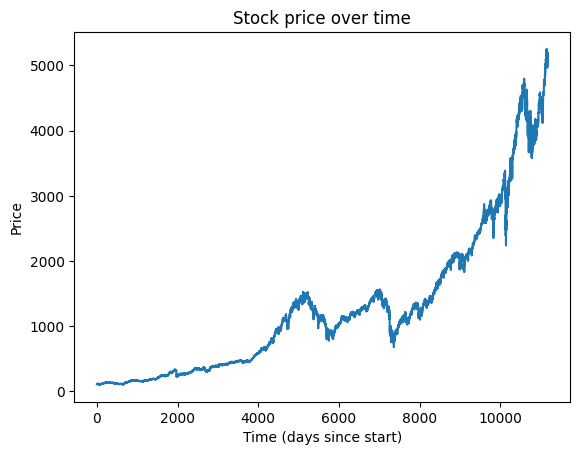

In [8]:
print(df, df.shape)
print(index.shape, df.T[0].shape)

plt.plot(index, df.T[0])
plt.title("Stock price over time")
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.show()

# How do we make the data fit for training?
In this case we decide to make bins of the past 365 days with a corresponding closing price value for the 366th day.


$X = [x_1, x_2, ..., x_n]$, each $x$ is a closing price

bins = $[X[x_1, x_2, ..., x_{k}], X[x_2, x_3, ..., x_{k + 1}] ... X[x_{n - k - 1}, x_{n - k}, ..., x_{n - 1}]]$, bin_size $= k$

$y = [x_2, x_3, ..., x_n]$

In [9]:
bins = bin_data(df, bin_size)

print(bins.shape)
print(bins[0][:5], bins[0].shape)
print(bins[1][:5], bins[1].shape)
print()
print(bins[-1][-10:])

# TODO
# 1.) Try a different bin size
# 2.) See if you can find the corresponding {y} value

(10815, 365)
[105.76000214 105.22000122 106.51999664 106.80999756 108.94999695] (365,)
[105.22000122 106.51999664 106.80999756 108.94999695 109.05000305] (365,)

[5010.60009766 5070.54980469 5071.62988281 5048.41992188 5099.95996094
 5116.16992188 5035.68994141 5018.39013672 5064.20019531 5127.79003906]


# Train and Test Split

Splitting data can be done any way you want. In most cases a 80% train and 20% test split works well, but this may not be the best split.
- The goal is to balance learning from the data and prevent overfitting, i.e. picking up on unnecessary noise.

In [18]:
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

print("train_size:", train_size)
print("test_size:", test_size)
print("x_size:", X_train.shape, X_test.shape)
print("y_size:", y_train.shape, y_test.shape)

# TODO
# 1.) Experiemnt with different train and test splits by modifying the split_data function.

train_size: 8652
test_size: 2163
x_size: (8652, 365) (2163, 365)
y_size: (8652,) (2163,)
